In [1]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import mse, binary_crossentropy

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
pandas:  2.0.0
numpy:  1.22.2
seaborn:  0.11.2
matplotlib:  3.7.1
sklearn:  1.2.2
Tensorflow:  2.7.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [3]:
filePath = './data/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])



In [5]:


x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')



(16320, 29) train samples
(4080, 29) test samples


In [6]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
#variational autoencoder
logfilename = "variationalautoencoder"


original_dim  = x_train.shape[1]

print(original_dim)

input_shape = (original_dim,)
intermediate_dim = 12
batch_size = 32
latent_dim = 2
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

29
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 12)           360         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            26          ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            26          ['dense[0][0]']                  
                                                                                         

In [8]:


vae.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
vae.summary()



Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          412         ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 29)           413         ['encoder[0][2]']                
                                                                                            

In [9]:
history = vae.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 [==============================] - 5s 5ms/step - loss: 49.5808 - accuracy: 0.0619 - val_loss: 48.4253 - val_accuracy: 0.1338
Epoch 2/20
510/510 [==============================] - 2s 4ms/step - loss: 46.5561 - accuracy: 0.1677 - val_loss: 47.7289 - val_accuracy: 0.2081
Epoch 3/20
510/510 [==============================] - 2s 4ms/step - loss: 46.1426 - accuracy: 0.2326 - val_loss: 47.4038 - val_accuracy: 0.2453
Epoch 4/20
510/510 [==============================] - 2s 4ms/step - loss: 45.9381 - accuracy: 0.2539 - val_loss: 47.2903 - val_accuracy: 0.2527
Epoch 5/20
510/510 [==============================] - 2s 4ms/step - loss: 45.8016 - accuracy: 0.2604 - val_loss: 47.1189 - val_accuracy: 0.2645
Epoch 6/20
510/510 [==============================] - 2s 4ms/step - loss: 45.6962 - accuracy: 0.2699 - val_loss: 47.0856 - val_accuracy: 0.2745
Epoch 7/20
510/510 [==============================] - 2s 4ms/step - loss: 45.6100 - accuracy: 0.2877 - val_loss: 46.9600 - val_accuracy:

In [10]:


score = vae.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



128/128 [==============================] - 0s 3ms/step - loss: 46.3963 - accuracy: 0.3449
Test loss: 46.39627456665039
Test accuracy: 0.3448529541492462


In [11]:
threshold=10.00
y_pred = vae.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [12]:
roc_auc_score(y_test, y_label)

0.9159364709499422

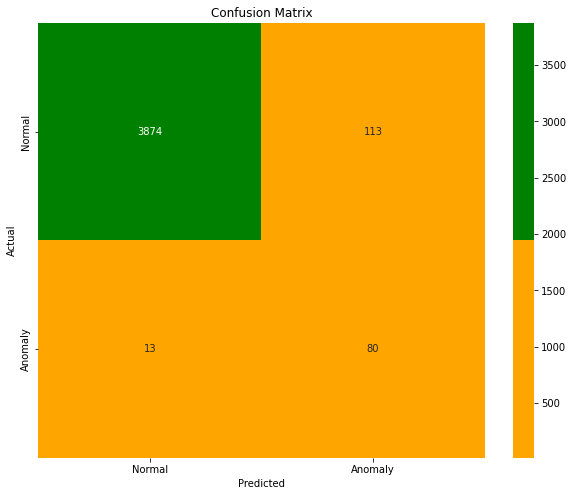

In [13]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

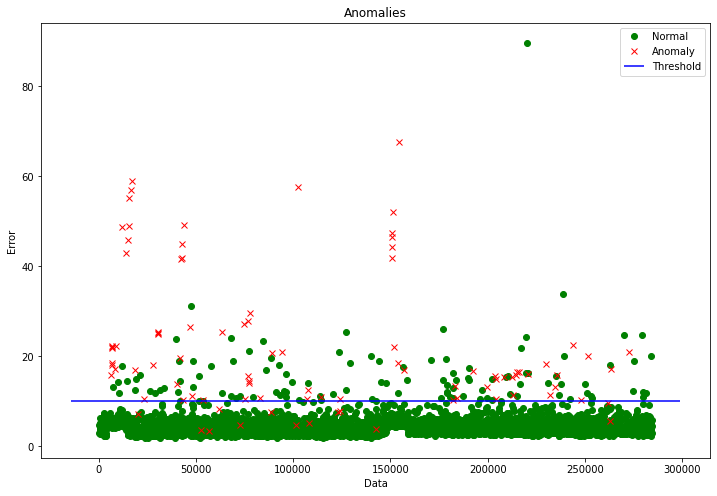

In [14]:
viz.draw_anomaly(y_test, error, threshold)